# Imports

In [1]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>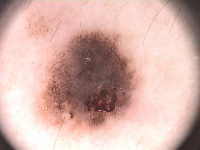</td><td>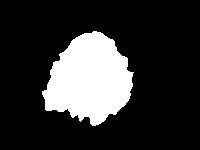</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [4]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar  -O ./data/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2025-05-06 19:32:35--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6022:18::a27d:4212, 162.125.70.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2025-05-06 19:32:35--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc74d3dcec08260cc2f1eb6c4d1.dl.dropboxusercontent.com/cd/0/inline/CpIQiz8zSKYCX81rrD_XOjn8YS8pK8oQLFJ0sBbDrv00dMbgrW9FASsTgTTRD1acjz5ZyQdrsbfweMjymOuzQ72eq6Tlnewh8DoIL-ONnwmZsADGWoUW0mITocSnAdGaxhc/file# [following]
--2025-05-06 19:32:36--  https://ucc74d3dcec08260cc2f1eb6c4d1.dl.dropboxusercontent.com/cd/0/inli

In [6]:
!ls ./data

PH2Dataset.rar


In [19]:
get_ipython().system_raw("unrar x ./data/PH2Dataset.rar ./data/")



UNRAR 7.00 freeware      Copyright (c) 1993-2024 Alexander Roshal


Extracting from ./data/PH2Dataset.rar

Creating    ./data/PH2Dataset                                         OK
Creating    ./data/PH2Dataset/PH2 Dataset images                      OK
Creating    ./data/PH2Dataset/PH2 Dataset images/IMD002               OK
Creating    ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp     0  OK 
Creating    ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion  OK
Extracting  ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp     0  OK 
Creating    ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi    OK
Extracting  ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R1_Label4.bmp     0  OK 
Extracting  ./data/PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R2_Label3.bmp     0  OK 
Creating    ./data/PH2Dataset/PH2 Dataset

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [20]:
images = []
lesions = []

root = './data/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [21]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [22]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [23]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

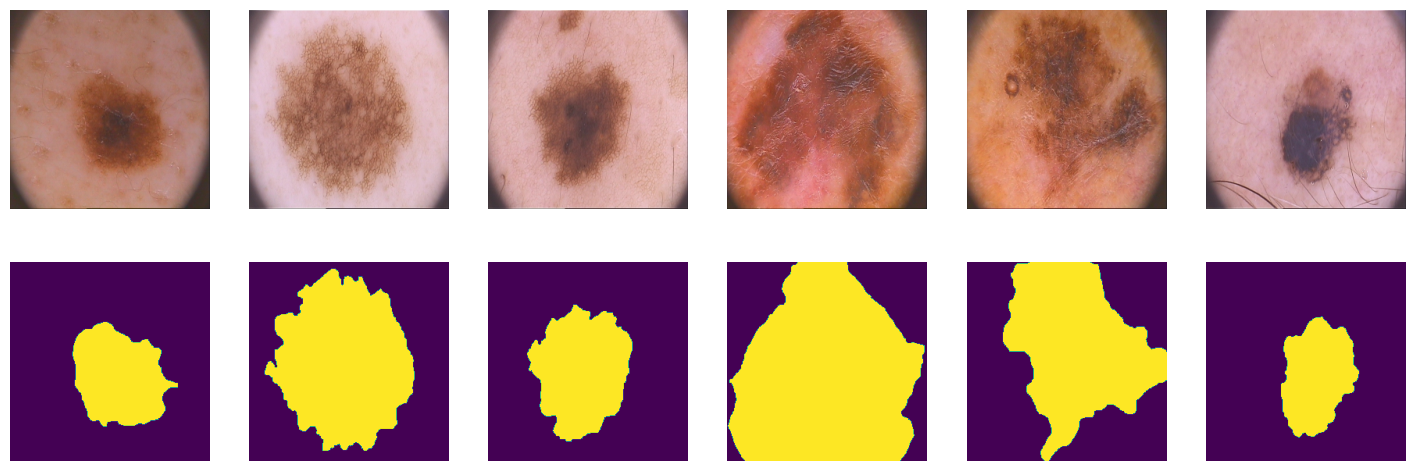

In [24]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [25]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [26]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [27]:
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

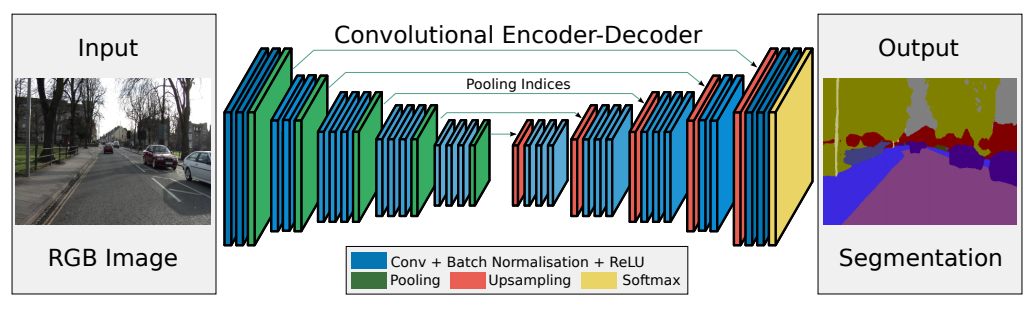

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
class SegNet(nn.Module):
    def __init__(self, num_classes=1, inp_ch=3): # Добавлен параметр num_classes и сделан inp_ch параметром
        """
        Инициализация модели SegNet.

        Args:
            num_classes (int): Количество выходных каналов (классов сегментации).
                               Для бинарной сегментации = 1.
            inp_ch (int): Количество каналов входного изображения (например, 3 для RGB).
        """
        super().__init__()

        # --- Энкодер (Encoder) ---
        # Каждый блок энкодера состоит из сверточных слоев (Conv2D -> BatchNorm -> ReLU)
        # и слоя Max Pooling для уменьшения пространственного разрешения.
        # Индексы максимальных значений сохраняются для использования в декодере.

        # Блок энкодера 0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), # inplace=True может немного сэкономить память
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # Уменьшение размера HxW / 2, сохраняем индексы

        # Блок энкодера 1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # Уменьшение размера HxW / 2, сохраняем индексы

        # Блок энкодера 2 (3 сверточных слоя, как в VGG)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # Уменьшение размера HxW / 2, сохраняем индексы

        # Блок энкодера 3 (3 сверточных слоя, как в VGG)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # Уменьшение размера HxW / 2, сохраняем индексы

        # --- Горлышко (Bottleneck) ---
        # В оригинальной архитектуре SegNet может не быть отдельного блока bottleneck с pooling/unpooling.
        # Этот блок выглядит как дополнительный энкодер-декодер шаг.
        # Возможно, это модификация или опечатка? Стандартный SegNet обычно переходит от pool3 к upsample0.
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # padding=(1,1) эквивалентно padding=1 для kernel_size=3
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # --- Эта часть нетипична для стандартного SegNet ---
        # self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # self.bottleneck_dec_conv = nn.Sequential(
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(inplace=True)
        # )
        # --- Конец нетипичной части ---

        # --- Декодер (Decoder) ---
        # Каждый блок декодера состоит из слоя MaxUnpooling (используя сохраненные индексы)
        # для увеличения пространственного разрешения и сверточных слоев (Conv2D -> BatchNorm -> ReLU).
        # Количество каналов постепенно уменьшается.

        # Блок декодера 0
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # Увеличение размера HxW * 2, используя индексы из pool3
        self.dec_conv0 = nn.Sequential(
            # Входные каналы должны соответствовать выходу bottleneck_conv (512)
            # Выходные каналы должны соответствовать каналам перед pool3 (512), или уменьшаться
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1), # Уменьшаем каналы до уровня enc_conv2
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Блок декодера 1
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # Увеличение размера HxW * 2, используя индексы из pool2
        self.dec_conv1 = nn.Sequential(
            # Входные каналы = 256 (из dec_conv0), выходные уменьшаются до уровня enc_conv1 (128)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # Уменьшаем каналы до уровня enc_conv1
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Блок декодера 2
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # Увеличение размера HxW * 2, используя индексы из pool1
        self.dec_conv2 = nn.Sequential(
            # Входные каналы = 128 (из dec_conv1), выходные уменьшаются до уровня enc_conv0 (64)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # Уменьшаем каналы до уровня enc_conv0
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Блок декодера 3 (финальный)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # Увеличение размера HxW * 2, используя индексы из pool0
        self.dec_conv3 = nn.Sequential(
            # Входные каналы = 64 (из dec_conv2), выходные уменьшаются до num_classes
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, padding=1) # Финальный сверточный слой до нужного числа классов
            # Здесь нет финальной функции активации (Sigmoid/Softmax).
            # Обычно ее применяют либо здесь, либо (что предпочтительнее)
            # используют функцию потерь, которая включает ее в себя (e.g., BCEWithLogitsLoss, CrossEntropyLoss).
        )

    def forward(self, x):
        """
        Прямой проход данных через сеть SegNet.

        Args:
            x (torch.Tensor): Входной тензор изображения (B, C, H, W).

        Returns:
            torch.Tensor: Выходной тензор сегментационной карты (B, num_classes, H, W).
        """
        # --- Энкодер ---
        # Прогоняем вход через блоки энкодера, сохраняя выходы и индексы пулинга
        e0_conv = self.enc_conv0(x)
        e0_pool, ind0 = self.pool0(e0_conv)

        e1_conv = self.enc_conv1(e0_pool)
        e1_pool, ind1 = self.pool1(e1_conv)

        e2_conv = self.enc_conv2(e1_pool)
        e2_pool, ind2 = self.pool2(e2_conv)

        e3_conv = self.enc_conv3(e2_pool)
        e3_pool, ind3 = self.pool3(e3_conv)

        # --- Горлышко (Bottleneck) ---
        # Прогоняем через сверточный блок горлышка
        b = self.bottleneck_conv(e3_pool)

        # --- Декодер ---
        # Прогоняем через блоки декодера, используя сохраненные индексы для MaxUnpooling
        # Необходимо передавать output_size в MaxUnpool2d, если размер тензора до пулинга был нечетным,
        # но т.к. stride=2 и padding=1 в Conv2D, размеры должны быть четными и совпадать.
        # Однако, для надежности можно передавать output_size=encoder_conv_output.size()
        d0_unpool = self.upsample0(b, ind3, output_size=e3_conv.size()) # Используем выход из bottleneck_conv 'b'
        d0_conv = self.dec_conv0(d0_unpool)

        d1_unpool = self.upsample1(d0_conv, ind2, output_size=e2_conv.size())
        d1_conv = self.dec_conv1(d1_unpool)

        d2_unpool = self.upsample2(d1_conv, ind1, output_size=e1_conv.size())
        d2_conv = self.dec_conv2(d2_unpool)

        d3_unpool = self.upsample3(d2_conv, ind0, output_size=e0_conv.size())
        out = self.dec_conv3(d3_unpool) # Финальный выход без активации

        return out

In [ ]:
print(summary(SegNet().to(device), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    """
    Вычисляет IoU (Intersection over Union) для двух тензоров PyTorch, представляющих маски сегментации.

    Args:
        outputs (torch.Tensor):  Тензор предсказанных масок. Имеет форму  BATCH x 1 x H x W.  Представляет собой выходные данные модели сегментации.
        labels (torch.Tensor):  Тензор истинных масок (ground truth). Имеет форму BATCH x 1 x H x W.

    Returns:
        torch.Tensor: Тензор IoU для каждого изображения в батче.  Имеет форму BATCH.
                      Значения нормализованы и масштабированы в диапазоне [0, 1].
    """

    # Если на вход подаются тензоры с разными формами (например, выход UNet),
    #  необходимо уменьшить размерность выходных данных.
    #  Например,  BATCH x 1 x H x W  становится BATCH x H x W
    outputs = outputs.squeeze(1).byte()  # Удаляем размерность канала (channel) и преобразуем в byte.  (BATCH x 1 x H x W -> BATCH x H x W)
    labels = labels.squeeze(1).byte()   # Удаляем размерность канала (channel) и преобразуем в byte. (BATCH x 1 x H x W -> BATCH x H x W)

    SMOOTH = 1e-8  # Небольшое значение для сглаживания, чтобы избежать деления на 0

    # Вычисление пересечения (intersection):
    #  Побитовое И (&) между предсказаниями и истинными метками.
    #  Суммируем по пикселям (1, 2), чтобы получить количество общих пикселей для каждого изображения в батче.
    intersection = (outputs & labels).float().sum((1, 2))  #  Сумма общих пикселей для каждого изображения в батче.

    # Вычисление объединения (union):
    #  Побитовое ИЛИ (|) между предсказаниями и истинными метками.
    #  Суммируем по пикселям (1, 2), чтобы получить общее количество пикселей, которые присутствуют либо в предсказании, либо в истинной метке.
    union = (outputs | labels).float().sum((1, 2))         # Сумма пикселей в объединении для каждого изображения в батче.

    # Вычисление IoU:
    #  IoU = Пересечение / Объединение.  Добавляем SMOOTH для избежания деления на 0.
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # IoU для каждого изображения в батче.

    # Пороговая обработка (thresholding):
    #  Применяем пороговое значение к IoU.  Преобразуем IoU в значения между 0 и 1.
    #  20 * (iou - 0.5):  Масштабирует и смещает IoU.
    #  torch.clamp(..., 0, 10): Ограничивает значения от 0 до 10.
    #  .ceil():  Округляет до ближайшего целого числа.
    #  / 10:  Нормализует значения между 0 и 1.
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # Пороговые значения IoU.

    return thresholded  # Возвращаем пороговые значения IoU.


In [63]:
# для модели, использующей кроп, вместо паддинга)
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    
    # Приведение к одинаковому размеру
    if outputs.shape != labels.shape:
        _, h_pred, w_pred = outputs.shape
        _, h_real, w_real = labels.shape
        crop_h = (h_real - h_pred) // 2
        crop_w = (w_real - w_pred) // 2
        labels = labels[:, crop_h:crop_h + h_pred, crop_w:crop_w + w_pred]

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded


## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    """
    Вычисляет Binary Cross Entropy (BCE) loss.

    Args:
        y_real (torch.Tensor): Истинные метки.  Должны быть 0 или 1.  
                                 Форма: [N, C, H, W]  (batch, channels, height, width) или [N, H, W]
        y_pred (torch.Tensor): Предсказанные логиты (выходные данные модели без сигмоиды).
                                 Форма: [N, C, H, W] или [N, H, W]

    Returns:
        torch.Tensor: Среднее значение BCE loss по всем элементам (пикселям).
    """

    # Разбиение формулы BCE loss на отдельные компоненты для читаемости:
    #  BCE loss вычисляется как - [y_real * log(sigmoid(y_pred)) + (1 - y_real) * log(1 - sigmoid(y_pred))]
    #  Однако, для стабильности и избежания проблем с численным расчетом,
    #  используется эквивалентная, но более стабильная форма, реализованная ниже.

    # term1:  \max(\hat{y}, 0),  где \hat{y} - y_pred (предсказанные логиты).
    # Используется для стабилизации вычислений и предотвращения переполнения.
    term1 = torch.maximum(y_pred, torch.zeros_like(y_pred))  # Берем максимум между y_pred и нулями.

    # term2: -y_pred * y_real.  y_real  ограничено в диапазоне [0, 1] чтобы избежать ошибок.
    term2 = -y_pred * torch.clamp(y_real, 0, 1) # Умножаем y_pred на y_real, используя torch.clamp для ограничения y_real.

    # term3:  \log(1 + \exp(-|\hat{y}|)).  Применяется для стабилизации вычислений с экспонентой,
    # чтобы избежать переполнения или потери точности.
    term3 = torch.log(1 + torch.exp(-torch.abs(y_pred)))  #  Вычисляем логарифм от (1 + exp(-abs(y_pred))).

    # Вычисление общей потери BCE:
    loss = term1 + term2 + term3 # Складываем три компонента вместе, чтобы получить общую потерю.

    # Усреднение по всем элементам (пикселям) для получения финального значения loss.
    return loss.mean() # Возвращаем среднее значение loss.


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [30]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    train_losses = []
    val_losses = []

    # Валидационный батч
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    for epoch in range(epochs):
        tic = time()
        print(f'* Epoch {epoch + 1}/{epochs}')
        model.train()

        avg_loss = 0.0

        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # sanity check
            Y_batch = torch.clamp(Y_batch, 0, 1)

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss.item() / len(data_tr)

        # Validation
        model.eval()
        with torch.no_grad():
            Y_val_pred = model(X_val)
            val_loss = loss_fn(Y_val_pred, Y_val).item()

        train_losses.append(avg_loss)
        val_losses.append(val_loss)

        # Обновление шедулера (если задан)
        if scheduler:
            scheduler.step(val_loss)

        toc = time()
        print(f'Loss: {avg_loss:.6f}, Val Loss: {val_loss:.6f}, Time: {toc - tic:.2f}s')

        # Визуализация результатов
        clear_output(wait=True)
        Y_hat = Y_val_pred.detach().cpu()

        for k in range(6):
            plt.subplot(2, 6, k + 1)
            plt.imshow(np.rollaxis(X_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k + 7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

        plt.suptitle(f'Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f}')
        plt.show()

        # График лоссов
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [67]:
def predict(model, data):
    model.eval()
    Y_pred = []
    with torch.no_grad():
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            pred = torch.sigmoid(pred)
            Y_pred.append(pred.cpu().numpy())
    return np.concatenate(Y_pred)

def score_model(model, metric, data):
    model.eval()
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch, Y_label = X_batch.to(device), Y_label.to(device)
            Y_pred = torch.sigmoid(model(X_batch)) > 0.5
            scores += metric(Y_pred, Y_label).mean().item()
    return scores / len(data)

#Функция для вычисления скора на валидации и тесте уже обученной модели
def scores(model):
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    print(f"\nScore на валидации: {val_score:.4f}, score на тесте: {test_score:.4f}")
    return val_score, test_score

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [33]:
torch.cuda.empty_cache()

In [ ]:
model = SegNet().to(device)

In [ ]:
# loss_model = bce_loss # самописный лосс
loss_model = torch.nn.BCEWithLogitsLoss() # готовый нормальный лосс)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

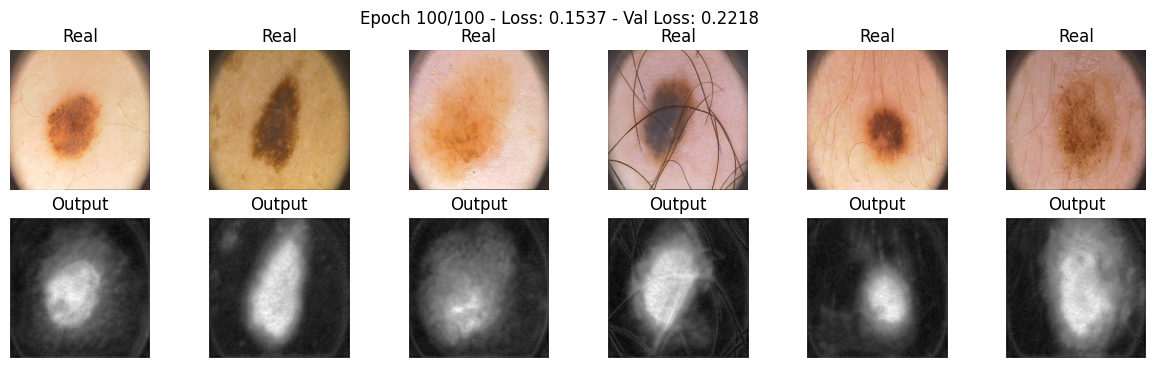

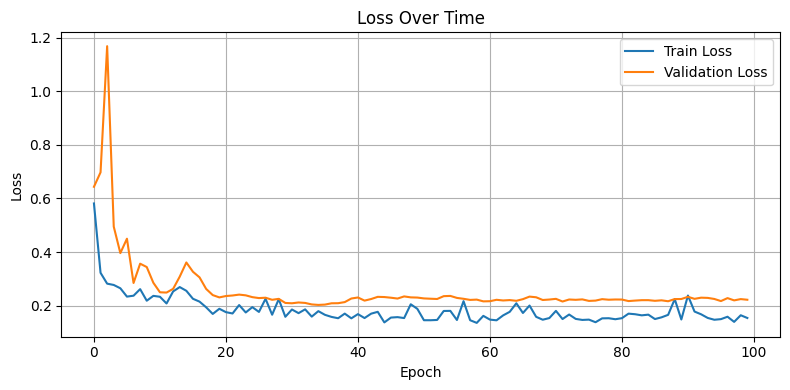

In [ ]:
max_epochs = 100
train(model, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores(model)


Score на валидации: 0.6406, score на тесте: 0.7078


(0.6406250149011612, 0.7078125178813934)

Ответьте себе на вопрос: не переобучается ли моя модель?

Я думаю ближе к 90ой эпохе модель начала переобучаться.
Но в целом, я считаю, что результат достигнут приемлемый для начала)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real, smooth=1): # параметр smooth решает проблему возможной нестабильности функции
    y_pred = torch.sigmoid(y_pred)
    num = (2*y_pred*y_real).sum((1,2,3)) + smooth
    den = (y_pred + y_real).sum((1,2,3)) + smooth
    res = 1 - (num/den).mean()
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

loss_model = dice_loss
optimizer = torch.optim.Adam(model_dice.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

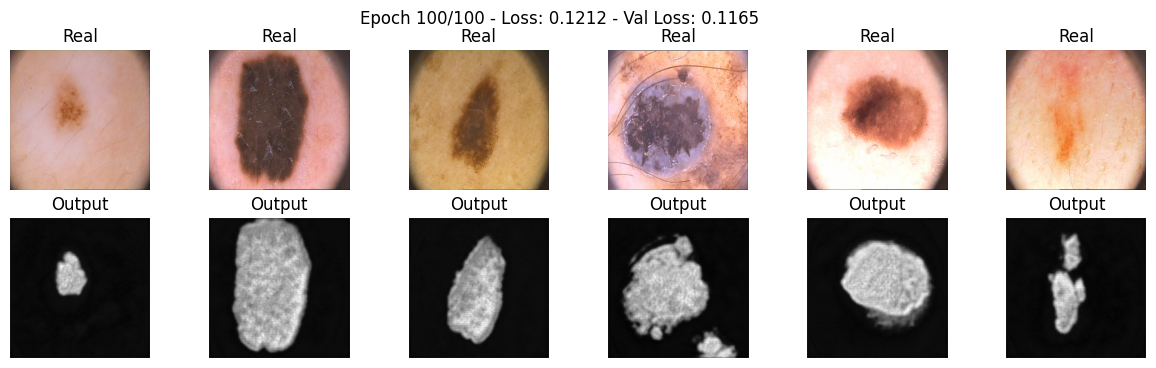

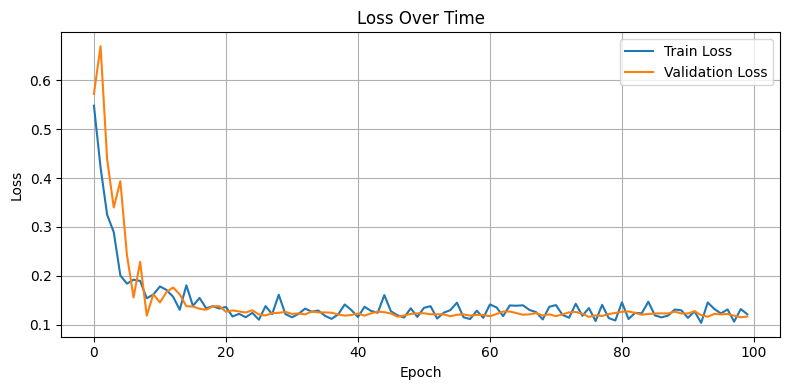

In [ ]:
max_epochs = 100
train(model_dice, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

In [ ]:
scores(model_dice)


Score на валидации: 0.6813, score на тесте: 0.6891


(0.6812500208616257, 0.6890625208616257)

Интересный получился итоговый результат.

На трейне и валидации мы видим, что лосс существенно ниже, чем ранее.

Но на тесте, модель показала результат хуже, чем предыдущая!) Не сильно, но похуже.

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


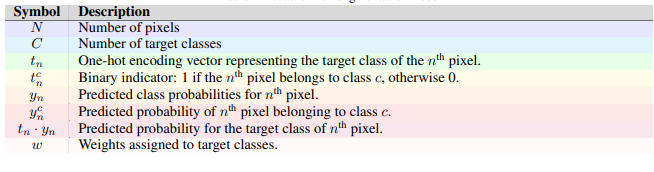

Another approach to deal with data imbalance is to use Focal loss. Focal loss is a modified version of the cross-entropy loss that assigns different weights to easy and hard samples. Here, hard samples are samples that are misclassified with a high probability while easy samples are those that are correctly classified with a high probability. This helps to balance the influence of easy and hard samples on the overall loss.
$$L_{focal}(y,t,γ) = -\sum_{n=1}^{N}(1-t_n \cdot y_n)^γ  log(t_n \cdot y_n)$$
where $γ$ is a non-negative tunable hyperparameter. 
When $γ$ is set to 0 for all samples, we get plain cross-entropy loss.

In [36]:
#eps - весовой коэффициент для балансировки дисбаланса классов (default -1)

def focal_loss(y_pred, y_real, eps = -1, gamma = 2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    # однако, для разнообразия (!) можно было бы использовать библиотечную функцию binary_cross_entropy_with_logits
    # ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")
    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if eps >= 0:
        alpha_t = eps * y_real + (1 - eps) * (1 - y_real)
        loss = alpha_t * loss
    loss = loss.mean((1,2,3)).mean()
    return loss


In [ ]:
model_focal = SegNet().to(device)

loss_model = focal_loss
optimizer = torch.optim.Adam(model_focal.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

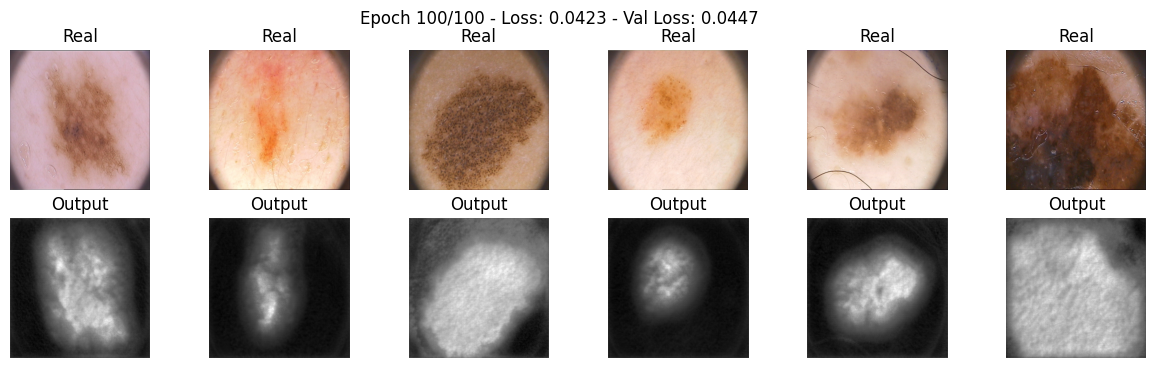

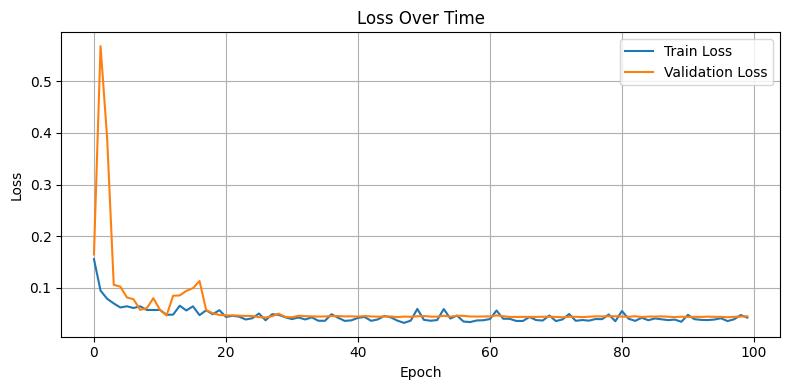

In [ ]:
max_epochs = 100
train(model_focal, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

С данной функцией потерь прям песня какая то, в пределах 0.04, посмотрим, как на тесте покажет себя такая модель!)

In [ ]:
scores(model_focal)


Score на валидации: 0.7188, score на тесте: 0.7078


(0.71875, 0.7078125327825546)

Ну, вообще результат вполне себе неплохой, хотя, мне кажется, возможно я считаю что то не так, ибо выше 0.70 на тесте выдать не удается, мне кажется, что должно быть лучше, но это не точно, при условии, что всего 100 трейновых изображений.

Возможно, если бы данных было больше...

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation

2) Lova

3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)

4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

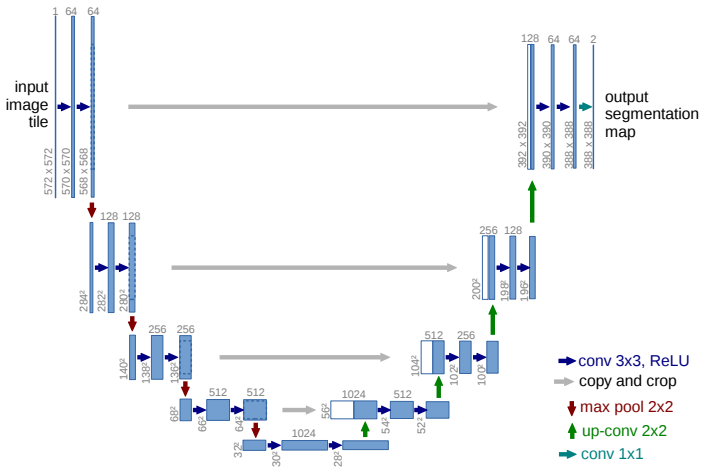

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

Далее авторы хотят, чтобы я реализовывал архитектуру с некоторыми изменениями, в частности, добавил паддинг=(1,1), т.к. и это разумно, но я все же сначала реализую оригинальную архитектуру, для лучшего ее понимания, тем способом, который понимаю, а уже потом буду работать и кодом от авторов.

## Оригинальный U-net из статьи.

Данная версия медленнее, похуже, но она менее точная на границах изображений, что может быть важно в случае с медицинскими изображениями!

In [38]:
# Класс двойной свертки, который будет использоваться на протяжении работы всей
# сети
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

def crop_tensor(target_tensor, reference_tensor):
    """Center crop target_tensor to match spatial size of reference_tensor."""
    target_size = target_tensor.size()[2:]
    reference_size = reference_tensor.size()[2:]
    delta_h = target_size[0] - reference_size[0]
    delta_w = target_size[1] - reference_size[1]
    cropped = target_tensor[:, :, delta_h // 2 : target_size[0] - (delta_h - delta_h // 2),
                                 delta_w // 2 : target_size[1] - (delta_w - delta_w // 2)]
    return cropped

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        x_conv = self.double_conv(x)
        x_down = self.down(x_conv)
        return x_conv, x_down

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2_cropped = crop_tensor(x2, x1)
        x = torch.cat([x2_cropped, x1], dim=1)
        return self.double_conv(x)

class OriginalUnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        return self.out(x)

В оригинале задания мы приводили все изображения к размеру 256х256 пикселей. Если работать с оригинальной U-net, то наши тензоры скукожатся до размера 8х8, что не есть хорошо, для обучения модельки, поэтому мы ее применять не будем.

Для меня было важно понять суть, зачем во многих источниках люди ссылаются на оригинальную статью, но при этом при описании архитектуры используют паддинг и при этом отказываются от crop.

Безусловно это удобно в рамках обучения, но это лишает других более глубокого понимания архитектуры.

Разобраться самому было интересно и важно для меня. Потому что читая статью и сравнивая архитектуры я не понимал, почему такие различия.

## Мой U-net с padding и без кропа

In [42]:
# Двойная свертка с активацией ReLU и padding = (1,1)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=(1,1))
        self.act = nn.ReLU(inplace=True)

    def forward(self,x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        out = self.act(x)
        return out

# Class DownSample: Блок понижающей дискретизации с двойной сверткой
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        out_double_conv = self.double_conv(x)
        out_down = self.down(out_double_conv)

        return out_double_conv, out_down

# Класс UpSample представляет собой модуль нейронной сети,
# выполняющий повышающую дискретизацию (upsampling) входного тензора и
# конкатенацию с тензором из skip connection.
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, (2,2), stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2], dim=1)
        out = self.double_conv(x)

        return out

# Class U-Net: Сегментационная нейронная сеть

class MyUnet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, (1,1))


    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        out = self.out(x)

        return out

## U-net как хотят авторы без кропа, но в BatchNorm

Мне не очень нравится алгоритм данной реализации, возможно, конечно он тоже практикует некое повторение для написания кода, но он, как будто существенно сложнее, нежели чем должен быть!)

Так же авторы хотят, чтобы в архитектуре присутствовал слой BatchNorm, это, безусловно помогает нам улучшить ситуацию в случае переобучения модели, за счет увеличение разнообразия данных. Своего рода аугментация.

Добавлю батчнорм и сравним все таки все три реализации модели.

In [46]:
class MPTI_UNet(nn.Module):
    def __init__(self, inp_ch=3, num_classes=1):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(inp_ch, 64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=False)# 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=False) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=False) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=False) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 256, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 128, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.upsample3 = nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # bottleneck
        b = self.bottleneck_conv(e7)

        # decoder
        d0 = self.upsample0(b)
        d1 = self.dec_conv0(torch.cat((d0, e6), dim=1))
        d2 = self.upsample1(d1)
        d3 = self.dec_conv1(torch.cat((d2, e4), dim=1))
        d4 = self.upsample2(d3)
        d5 = self.dec_conv2(torch.cat((d4, e2), dim=1))
        d6 = self.upsample3(d5)
        out = self.dec_conv3(torch.cat((d6, e0), dim=1)) # no activation

        return out

In [ ]:
# unet_model = UNet().to(device)
# train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)
# score_model(unet_model, iou_pytorch, data_val)

In [43]:
torch.cuda.empty_cache()

In [40]:
# focal loss для оригинальной сети
def focal_loss(y_pred, y_real, eps=-1, gamma=2):
    # Если размеры не совпадают, обрежем y_real по центру
    if y_pred.shape != y_real.shape:
        _, _, h_pred, w_pred = y_pred.shape
        _, _, h_real, w_real = y_real.shape
        crop_h = (h_real - h_pred) // 2
        crop_w = (w_real - w_pred) // 2
        y_real = y_real[:, :, crop_h:crop_h + h_pred, crop_w:crop_w + w_pred]

    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred * y_real + torch.log1p(torch.exp(-torch.abs(y_pred)))
    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if eps >= 0:
        alpha_t = eps * y_real + (1 - eps) * (1 - y_real)
        loss = alpha_t * loss

    return loss.mean((1, 2, 3)).mean()


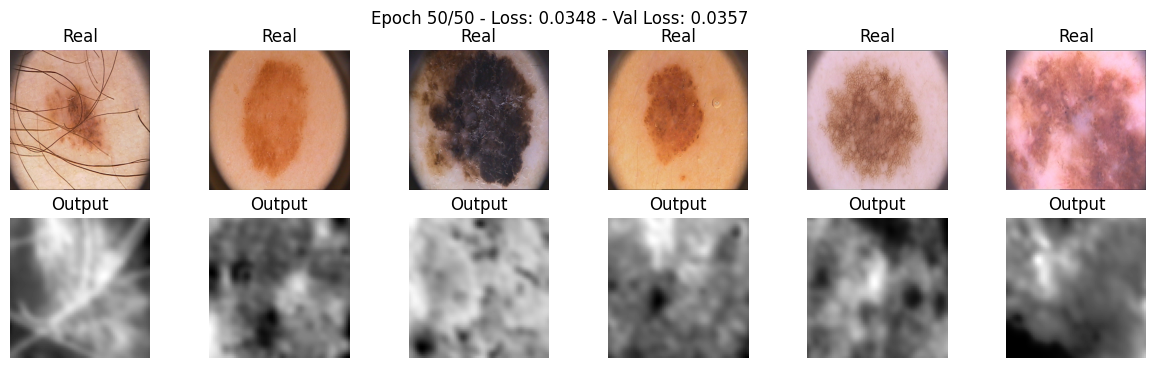

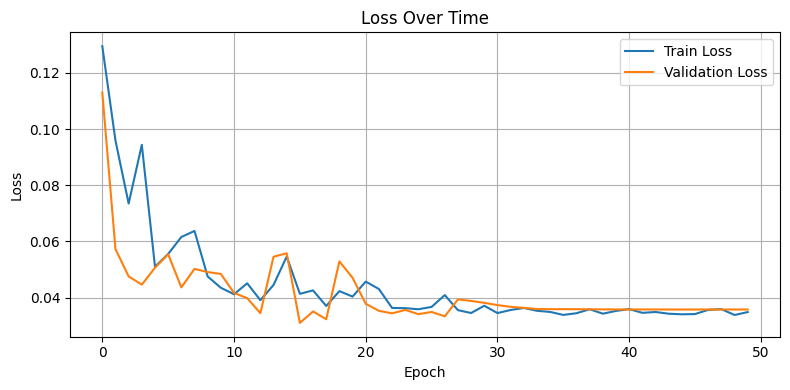

In [ ]:
# все будут обучаться с одной функцией потерь и едиными настройками
# инициализируем и обучим первую модель
original_model = OriginalUnet().to(device)

loss_model = focal_loss
optimizer = torch.optim.Adam(original_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

max_epochs = 50
train(original_model, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

Судя по выводу модели, что то не так, посмотрим что будет на тесте.

Велика вероятность, что я напортачил с лосом.

In [44]:
# Для сетей с падингами
def focal_loss(y_pred, y_real, eps = -1, gamma = 2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    # однако, для разнообразия (!) можно было бы использовать библиотечную функцию binary_cross_entropy_with_logits
    # ce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")
    p_t = p * y_real + (1 - p) * (1 - y_real)
    loss = ce_loss * ((1 - p_t) ** gamma)
    if eps >= 0:
        alpha_t = eps * y_real + (1 - eps) * (1 - y_real)
        loss = alpha_t * loss
    loss = loss.mean((1,2,3)).mean()
    return loss

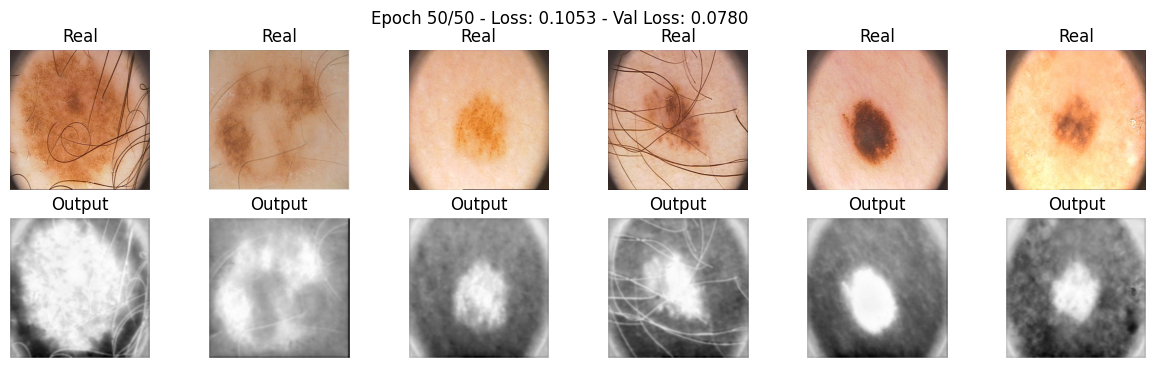

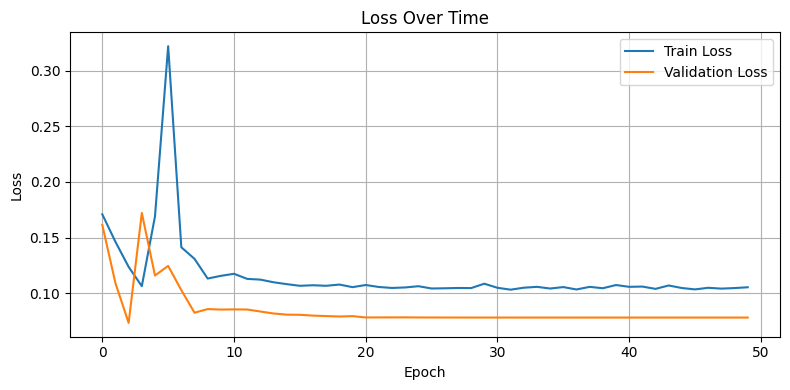

In [45]:
torch.cuda.empty_cache()

my_model = MyUnet().to(device)
loss_model = focal_loss
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)


max_epochs = 50
train(my_model, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

Моя модель показала неплохой результат в целом.

Думаю, если добавить БатчНорм, то результат можно будет улучшить.

В целом модель не переобучается, но и сходиться перестала по сле 10ой эпохи.

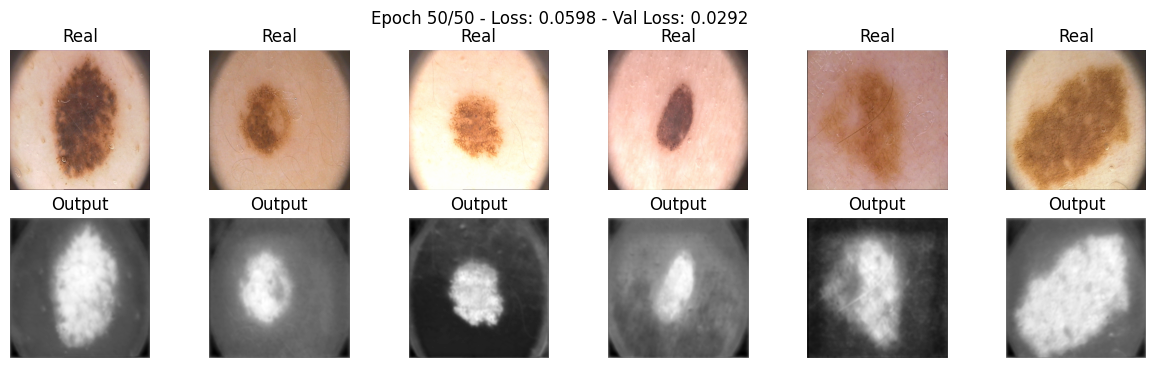

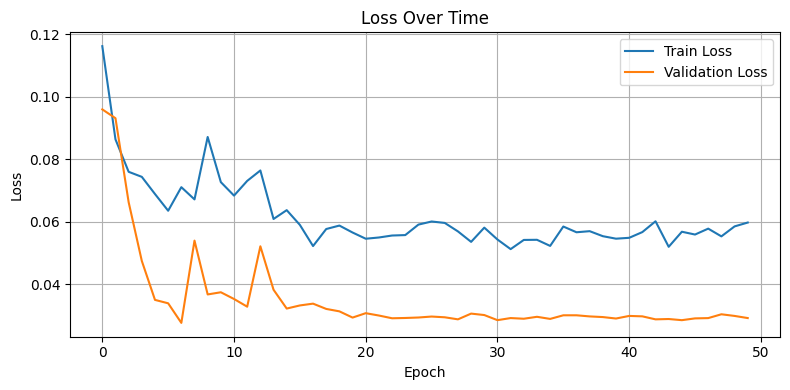

In [47]:
torch.cuda.empty_cache()

mpti_model = MPTI_UNet().to(device)
loss_model = focal_loss
optimizer = torch.optim.Adam(mpti_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

max_epochs = 50
train(mpti_model, optimizer, loss_model, max_epochs, data_tr, data_val, scheduler)

Функция потерь была ниже, но после 15ой эпохи тоже перестала особо сходиться, даже появились признаки переобучения.

Чтож посмотрим, что модельки покажут на тестовых данных...)

In [65]:
scores(original_model)


Score на валидации: 0.8964, score на тесте: 0.9339


(0.8964285765375409, 0.9339285833495004)

Очень странный результат, т.к. судя по тем картам, которые мне выдает модель, ее предсказания должны быть существенно хуже, возможно у меня есть ошибка....

In [68]:
scores(my_model)


Score на валидации: 0.3589, score на тесте: 0.3893


(0.35892856972558157, 0.3892857219491686)

Вот этот результат. конечно. очень странный получился.
Вероятно, необходимо поработать с порогами значений.

Построить гистограммы, посмотреть что да как, потому что судя по картам, которые модель предсказывает значения очень неплохие

In [69]:
scores(mpti_model)


Score на валидации: 0.6286, score на тесте: 0.5875


(0.6285714379378727, 0.5875000144754138)

Очень интересно выходит однако) 

Видимо. где то закралась существенная некая ошибка. Иначе я даже не знаю, как сие объяснить)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.